In [135]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [136]:
import sys
sys.path.append('../')

from game_runner import NegotitaionGame
from eval.game_evaluator import GameEvaluator
import agents.simple_agent as simple_agent
import agents.llm_agent as llm_agent
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from prompts.make_prompt import make_prompt
from metrics.visualizations import (
    plot_discounted_values,
    plot_offer_evolution,
    plot_negotiation_gap,
    plot_fairness
)

pathology_results = pd.DataFrame() #Store total game pathology results
#Add COLUMNS 


In [137]:
def calculate_discounted_value(offer, values, gamma, round_num):
    if offer is None:
        return 0
    base_value = sum(v * q for v, q in zip(values, offer))
    return base_value * (gamma ** (round_num - 1))


In [138]:
prompt_style = 'maximize_value'
date = '11_11_2024'
max_rounds = 3


rounds = []
p1_values = []
p2_values = []
games = 100 #SPECIFY NUMBER OF GAMES TO RUN
#LOOP TO RUN NEGOTIATION
for i in range(games):
    rounds = []
    p1_values = []
    p2_values = []
    p1_offers = []
    p2_offers = []
    rounds = []
    p1_values = []
    p2_values = []
    

    game = NegotitaionGame(
        player1_agent=llm_agent.LLMAgent(player_num=0),
        player2_agent=llm_agent.LLMAgent(player_num=1),
        num_items=5,
        item_value_range=[1, 101],
        gamma=0.9,
        max_rounds=max_rounds,
        outside_offer_value_range=[1, 1000]
    )
    game.game_results = pd.DataFrame(columns=[ #Set up dataframe to store game pathology results
        "game_num", "round_num", "player", "discount_rate", "offer", "value", "items",
        "your_side_of_current_offer", "outside_offer", "accepting_an_offer_worse_than_outside_offer",
        "making_an_offer_worse_for_you_than_your_outside_offer",
        "walking_away_from_an_offer_better_than_your_outside_offer",
        "offer_no_items_or_all_items", "making_offer_worse_than_previous"
    ]) 
    while game.in_progress:  
        current_step = len(game.history[0]) + len(game.history[1]) + 1
        current_round = (current_step - 1) // 2 + 1 
        current_player = 1 if current_step % 2 == 1 else 2
        game.current_round = current_round
        your_side_of_current_offer = None
        '''
        PATHOLOGIES
        '''
        making_offer_worse_than_previous = False #ONLY OCCURS IN NON-FINAL ROUNDS
        making_offer_worse_than_outside_offer = False #ONLY OCCURS IN NON-FINAL ROUNDS
        offer_no_items_or_all_items = False #ONLY OCCURS IN NON-FINAL ROUNDS
        accepting_an_offer_worse_than_outside_offer = False #ONLY OCCURS IN FINAL ROUND
        walking_away_from_an_offer_better_than_outside_offer = False #ONLY OCCURS IN FINAL ROUND

        print(f"\n{'='*80}")
        print(f"Game {i+1}, Round {current_round}, Player {current_player}'s turn (Step {current_step})")
        print(f"{'='*80}")

        prev_offer = game.current_offer  
        game.step()  
        
        if game.current_offer: #NORMAL ROUNDS or immediate walk away
            #p1_kept = game.items - np.array(game.current_offer.offer)
        # p1_value = calculate_discounted_value(p1_kept, game.player_values[0], game.gamma, current_round)
            #p2_value = calculate_discounted_value(game.current_offer.offer, game.player_values[1], game.gamma, current_round)
          
            if current_player == 1:

                p1_kept = game.items - np.array(game.current_offer.offer)
                p1_value = calculate_discounted_value(p1_kept, game.player_values[0], game.gamma, current_round)
                p2_value = calculate_discounted_value(game.current_offer.offer, game.player_values[1], game.gamma, current_round)
                rounds.append(current_round)
                p1_values.append(p1_value) #discounted value P1 would get from the current offer
                p2_values.append(p2_value) #discounted value P2 would get from the current offer
                
            if current_player == 2: #PLAYER 2 OFFERS
                rounds.append(current_round)
                p1_kept = game.items - np.array(game.current_offer.offer)
                p1_value = calculate_discounted_value(p1_kept, game.player_values[0], game.gamma, current_round)
                p2_value = calculate_discounted_value(game.current_offer.offer, game.player_values[1], game.gamma, current_round)
                p1_values.append(p1_value) #discounted value P1 would get from the current offer
                p2_values.append(p2_value) #discounted value P2 would get from the current offer
                p1_offers.append(prev_offer.offer)  
                p2_offers.append(game.current_offer.offer)
                
                print(f"\nRound {current_round} Values:")
                print(f"Player 1: {p1_value:.2f}")
                print(f"Player 2: {p2_value:.2f}")
            
            '''
            PATHOLOGY 1: Immediate offer was worse than just offer you just rejected
            '''
            
            if (game.current_round == 1 and current_player == 2) or game.current_round > 1: #CHECK OFFER IS BETTER THAN PREVIOUS OFFER
                if current_player == 1:
                    your_side_of_previous_offer = p1_values[-2] #P1's value from the P2's previous offer
                    your_side_of_current_offer = p1_values[-1] #P1's value from the current offer
                else:
                    your_side_of_previous_offer = p2_values[-2] #P2's value from the P1's previous offer
                    your_side_of_current_offer = p2_values[-1] #P2's value from the current offer

                if your_side_of_previous_offer > your_side_of_current_offer:
                    making_offer_worse_than_previous = True
                else:
                    making_offer_worse_than_previous = False 
            
            '''
            PATHOLOGY 2: Immediate offer was worse than your outside offer
            '''
            if current_player == 1:
                if p1_value < game.outside_offer_values[0] * (game.gamma ** (current_round - 1)):
                    making_offer_worse_than_outside_offer = True
                else:
                    making_offer_worse_than_outside_offer = False
            else:
                if p2_value < game.outside_offer_values[1] * (game.gamma ** (current_round - 1)):
                    making_offer_worse_than_outside_offer = True
                else:
                    making_offer_worse_than_outside_offer = False
            
            '''
            PATHOLOGY 3: Offer had no items or all items
            '''
            if current_player == 1:
                # Convert to lists for comparison or use np.array_equal
                if (np.array_equal(game.current_offer.offer, [0] * game.num_items) or 
                    np.array_equal(game.current_offer.offer, game.items)):
                    offer_no_items_or_all_items = True
            else:
                # Same for player 2
                if (np.array_equal(game.current_offer.offer, [0] * game.num_items) or 
                    np.array_equal(game.current_offer.offer, game.items)):
                    offer_no_items_or_all_items = True

            '''
            PATHOLOGY 4: Accepting an offer worse than your outside offer
            '''
            if current_player == 1 and game.final_action_player.action == "ACCEPT":
                if p1_value < game.outside_offer_values[0] * (game.gamma ** (current_round - 1)):
                    accepting_an_offer_worse_than_outside_offer = True
            elif current_player == 2 and game.final_action_player.action == "ACCEPT":
                if p2_value < game.outside_offer_values[1] * (game.gamma ** (current_round - 1)):
                    accepting_an_offer_worse_than_outside_offer = True

            '''
            PATHOLOGY 5: Walking away from an offer better than your outside offer
            '''
            if current_player == 1 and game.final_action_player.action == "WALK" or game.final_action_player.action == "COUNTEROFFER":
                if p1_value > game.outside_offer_values[0] * (game.gamma ** (current_round - 1)):
                    walking_away_from_an_offer_better_than_outside_offer = True
            elif current_player == 2 and (game.final_action_player.action == "WALK" or game.final_action_player.action == "COUNTEROFFER"):
                if p2_value > game.outside_offer_values[1] * (game.gamma ** (current_round - 1)):
                    walking_away_from_an_offer_better_than_outside_offer = True

            game.game_results = pd.concat([game.game_results, pd.DataFrame([{ 
                "game_num": i, "round_num": current_round, "player": current_player, "discount_rate": game.gamma ** (current_round - 1), "offer": game.current_offer.offer, "value": p1_value if current_player == 1 else p2_value, "items": game.items,
                "your_side_of_current_offer": your_side_of_current_offer, "outside_offer": game.outside_offer_values[current_player - 1] * (game.gamma ** (current_round - 1)), "accepting_an_offer_worse_than_outside_offer": accepting_an_offer_worse_than_outside_offer,
                "making_an_offer_worse_for_you_than_your_outside_offer": making_offer_worse_than_outside_offer, "walking_away_from_an_offer_better_than_your_outside_offer": walking_away_from_an_offer_better_than_outside_offer,
                "offer_no_items_or_all_items": offer_no_items_or_all_items, "making_offer_worse_than_previous": making_offer_worse_than_previous
            }])], ignore_index=True)    
        '''
        FINAL POSSIBLE ROUND PRINT STATEMENTS
        '''
        if current_round == game.max_rounds and current_player == 2: #IF WE ARE ON THE LAST ROUND
            if game.current_offer and game.current_offer != prev_offer: #IF PLAYER 2 MAKES A COUNTEROFFER WE TREAT IT AS WALK
                print(f"\nPlayer 2's final action: COUNTEROFFER {game.current_offer.offer}")
                p1_value = game.outside_offer_values[0] * (game.gamma ** (current_round - 1))
                p2_value = game.outside_offer_values[1] * (game.gamma ** (current_round - 1))
                print("\nGame ended after max rounds - both players get outside offers")
            elif game.current_offer == prev_offer: #IF PLAYER 2 ACCEPTS
                print("\nPlayer 2's final action: ACCEPT")
                p1_kept = game.items - np.array(game.current_offer.offer)
                p1_value = calculate_discounted_value(p1_kept, game.player_values[0], game.gamma, current_round)
                p2_value = calculate_discounted_value(game.current_offer.offer, game.player_values[1], game.gamma, current_round)
            else: #IF PLAYER 2 WALKS
                print("\nPlayer 2's final action: WALK")
                p1_value = game.outside_offer_values[0] * (game.gamma ** (current_round - 1))
                p2_value = game.outside_offer_values[1] * (game.gamma ** (current_round - 1))
                print("\nGame ended after max rounds - both players get outside offers")
            
            game.in_progress = False
            print(f"\nRound {current_round} Final Values:")
            print(f"Player 1: {p1_value:.2f}")
            print(f"Player 2: {p2_value:.2f}")
            
            rounds.append(current_round)
            p1_values.append(p1_value)
            p2_values.append(p2_value)
            break
        #TODO ASK ABOUT THIS CASE (WALK) -> currently treated as not being a pathology at all 
        elif game.current_offer is None and current_player == 1 and game.final_action_player.action == "WALK": #IF PLAYER 1 MAKES AN INVALID OFFER
            game.game_results = pd.concat([game.game_results, pd.DataFrame([{ 
                "game_num": i, "round_num": current_round, "player": current_player, "discount_rate": game.gamma ** (current_round - 1), "offer": [], "value": None, "items": game.items,
                "your_side_of_current_offer": None, "outside_offer": None, "accepting_an_offer_worse_than_outside_offer": None,
                "making_an_offer_worse_for_you_than_your_outside_offer": None, "walking_away_from_an_offer_better_than_your_outside_offer": None,
                "offer_no_items_or_all_items": None, "making_offer_worse_than_previous": None
            }])], ignore_index=True) 
            game.in_progress = False

    pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)
        
    
pathology_results.to_csv(f'pathology_results_{date}_{games}_{prompt_style}.csv', index=False)





Game 1, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 2 units of item 1, 6 units of item 2, 4 units of item 3, 4 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 18 for item 1, 60 for item 2, 86 for item 3, 39 for item 4, 14 for item 5.
    Both you and Player 2 also have a private outside offer, of value drawn from a uniform random distribution, ranging from 1 to 1000.
    Your outside offer value is 79. Your objective is to maximize your value of the outcome of the negotiation game.

    The negotiation proceeds in 3 rounds.
    There is a discount rate gamma = 0.9, such that if the process conclu

## Statistics of Play for Each Player Over Games

In [140]:
# Read the CSV data
df = pd.read_csv(f'../experiments/pathology_results_{date}_{games}_{prompt_style}.csv')

def analyze_pathology_comprehensive(df, pathology_name, is_game_ending_pathology=False):
    total_games = df['game_num'].nunique()

    if is_game_ending_pathology:
        # Identify moves where the pathology occurred
        #pathology_moves = df[df[pathology_name]]
        pathology_moves = df[df[pathology_name].fillna(False)]

        # Get the first occurrence per game (since game ends after pathology)
        first_pathology_moves = pathology_moves.groupby('game_num').first().reset_index()

        # Overall count of games with the pathology
        overall_count = len(first_pathology_moves)

        print(f"\n=== {pathology_name} ===")
        print(f"\nOverall: {overall_count}/{total_games} ({(overall_count/total_games*100):.1f}%)")

        # Count per player
        player_counts = first_pathology_moves['player'].value_counts()

        for player in [1, 2]:
            player_count = player_counts.get(player, 0)
            print(f"Player {player}: {player_count}/{total_games} ({(player_count/total_games*100):.1f}%)")

        # Count per round
        round_counts = first_pathology_moves['round_num'].value_counts()
        for round_num in sorted(df['round_num'].unique()):
            round_count = round_counts.get(round_num, 0)
            print(f"Round {round_num}: {round_count}/{total_games} ({(round_count/total_games*100):.1f}%)")

    else:
        # Identify the first occurrence of a game-ending pathology per game
        game_ending_moves = df[df[['accepting_an_offer_worse_than_outside_offer',
                                   'walking_away_from_an_offer_better_than_your_outside_offer']].any(axis=1)]
        first_game_ending_round = game_ending_moves.groupby('game_num')['round_num'].min()

        # Function to get valid moves (before any game-ending pathology occurs)
        def get_valid_moves(group):
            game_num = group['game_num'].iloc[0]
            if game_num in first_game_ending_round.index:
                pathology_round = first_game_ending_round.loc[game_num]
                return group[group['round_num'] < pathology_round]  # Exclude the pathology round and after
            else:
                return group  # Include all moves if no game-ending pathology occurred

        # Apply the function to get all valid moves before game-ending pathologies
        valid_moves = df.groupby('game_num').apply(get_valid_moves).reset_index(drop=True)

        total_moves = len(valid_moves)
        count = valid_moves[pathology_name].sum()

        print(f"\n=== {pathology_name} ===")
        print(f"\nOverall: {int(count)}/{total_moves} ({(count/total_moves*100):.1f}%)")

        # By Player
        for player in [1, 2]:
            player_moves = valid_moves[valid_moves['player'] == player]
            player_count = player_moves[pathology_name].sum()
            moves = len(player_moves)
            if moves > 0:
                print(f"Player {player}: {int(player_count)}/{moves} ({(player_count/moves*100):.1f}%)")

        # By Round
        for round_num in sorted(valid_moves['round_num'].unique()):
            round_moves = valid_moves[valid_moves['round_num'] == round_num]
            round_count = round_moves[pathology_name].sum()
            moves_in_round = len(round_moves)
            if moves_in_round > 0:
                print(f"Round {round_num}: {int(round_count)}/{moves_in_round} ({(round_count/moves_in_round*100):.1f}%)")

# Define pathology types
game_ending_pathologies = [
    'accepting_an_offer_worse_than_outside_offer',
    'walking_away_from_an_offer_better_than_your_outside_offer'
]

per_move_pathologies = [
    'making_an_offer_worse_for_you_than_your_outside_offer',
    'offer_no_items_or_all_items',
    'making_offer_worse_than_previous'
]

# Analyze each pathology
for pathology in game_ending_pathologies:
    analyze_pathology_comprehensive(df, pathology, is_game_ending_pathology=True)

for pathology in per_move_pathologies:
    analyze_pathology_comprehensive(df, pathology, is_game_ending_pathology=False)


=== accepting_an_offer_worse_than_outside_offer ===

Overall: 10/100 (10.0%)
Player 1: 7/100 (7.0%)
Player 2: 3/100 (3.0%)
Round 1: 0/100 (0.0%)
Round 2: 0/100 (0.0%)
Round 3: 10/100 (10.0%)

=== walking_away_from_an_offer_better_than_your_outside_offer ===

Overall: 56/100 (56.0%)
Player 1: 9/100 (9.0%)
Player 2: 47/100 (47.0%)
Round 1: 45/100 (45.0%)
Round 2: 11/100 (11.0%)
Round 3: 0/100 (0.0%)

=== making_an_offer_worse_for_you_than_your_outside_offer ===

Overall: 107/174 (61.5%)
Player 1: 79/106 (74.5%)
Player 2: 28/68 (41.2%)
Round 1: 52/96 (54.2%)
Round 2: 38/56 (67.9%)
Round 3: 17/22 (77.3%)

=== offer_no_items_or_all_items ===

Overall: 4/174 (2.3%)
Player 1: 3/106 (2.8%)
Player 2: 1/68 (1.5%)
Round 1: 4/96 (4.2%)
Round 2: 0/56 (0.0%)
Round 3: 0/22 (0.0%)

=== making_offer_worse_than_previous ===

Overall: 65/174 (37.4%)
Player 1: 32/106 (30.2%)
Player 2: 33/68 (48.5%)
Round 1: 18/96 (18.8%)
Round 2: 34/56 (60.7%)
Round 3: 13/22 (59.1%)


In [144]:
# Read the CSV data
df = pd.read_csv(f'../experiments/pathology_results_{date}_{games}_{prompt_style}.csv')
#df = pd.read_csv(f'../experiments/pathology_results_basic_11_11_2024_100_basic.csv')

def analyze_pathology_comprehensive(df, pathology_name, is_game_ending_pathology=False):
    total_games = df['game_num'].nunique()
    
    if is_game_ending_pathology:
        # For game-ending pathologies, possible occurrences = total number of games
        total_possible_occurrences = total_games
        
        # Count games where the pathology occurred
        pathology_games = df[df[pathology_name].fillna(False)]['game_num'].nunique()
        
        print(f"\n=== {pathology_name} ===")
        print(f"\nOverall: {pathology_games}/{total_possible_occurrences} ({(pathology_games/total_possible_occurrences*100):.1f}%)")
        
        # Counts per player
        pathology_games_by_player = df[df[pathology_name].fillna(False)].groupby('player')['game_num'].nunique()
        for player in [1, 2]:
            player_count = pathology_games_by_player.get(player, 0)
            print(f"Player {player}: {player_count}/{total_possible_occurrences} ({(player_count/total_possible_occurrences*100):.1f}%)")
        
        # Counts per round
        pathology_games_by_round = df[df[pathology_name].fillna(False)].groupby('round_num')['game_num'].nunique()
        for round_num in sorted(df['round_num'].unique()):
            round_count = pathology_games_by_round.get(round_num, 0)
            print(f"Round {round_num}: {round_count}/{total_possible_occurrences} ({(round_count/total_possible_occurrences*100):.1f}%)")
    else:
        total_steps = len(df) #total number of moves
        total_games = df['game_num'].nunique() #total number of games
        # For per-move pathologies, possible occurrences = total steps minus total games (assuming pathology cannot occur in the first move of each game)
        total_possible_occurrences = total_steps - total_games
        
        # Count steps where the pathology occurred
        pathology_occurrences = df[df[pathology_name].fillna(False)]
        total_pathology_occurrences = len(pathology_occurrences)
        
        print(f"\n=== {pathology_name} ===")
        print(f"\nOverall: {total_pathology_occurrences}/{total_possible_occurrences} ({(total_pathology_occurrences/total_possible_occurrences*100):.1f}%)")
        
        # Counts per player
        for player in [1, 2]:
            player_occurrences = len(pathology_occurrences[pathology_occurrences['player'] == player])
            total_player_steps = len(df[df['player'] == player]) - total_games  # Subtract initial moves
            print(f"Player {player}: {player_occurrences}/{total_player_steps} ({(player_occurrences/total_player_steps*100):.1f}%)")
        
        # Counts per round
        for round_num in sorted(df['round_num'].unique()):
            if round_num == 1:
                # Subtract initial moves in round 1
                steps_in_round = len(df[df['round_num'] == round_num]) - total_games
            else:
                steps_in_round = len(df[df['round_num'] == round_num])
            round_occurrences = len(pathology_occurrences[pathology_occurrences['round_num'] == round_num])
            print(f"Round {round_num}: {round_occurrences}/{steps_in_round} ({(round_occurrences/steps_in_round*100):.1f}%)")

# Define pathology types
game_ending_pathologies = [
    'accepting_an_offer_worse_than_outside_offer',
    'walking_away_from_an_offer_better_than_your_outside_offer'
]

per_move_pathologies = [
    'making_an_offer_worse_for_you_than_your_outside_offer',
    'offer_no_items_or_all_items',
    'making_offer_worse_than_previous'
]

# Analyze each pathology
for pathology in game_ending_pathologies:
    analyze_pathology_comprehensive(df, pathology, is_game_ending_pathology=True)

for pathology in per_move_pathologies:
    analyze_pathology_comprehensive(df, pathology, is_game_ending_pathology=False)


=== accepting_an_offer_worse_than_outside_offer ===

Overall: 10/100 (10.0%)
Player 1: 7/100 (7.0%)
Player 2: 3/100 (3.0%)
Round 1: 0/100 (0.0%)
Round 2: 0/100 (0.0%)
Round 3: 10/100 (10.0%)

=== walking_away_from_an_offer_better_than_your_outside_offer ===

Overall: 56/100 (56.0%)
Player 1: 47/100 (47.0%)
Player 2: 51/100 (51.0%)
Round 1: 45/100 (45.0%)
Round 2: 49/100 (49.0%)
Round 3: 23/100 (23.0%)

=== making_an_offer_worse_for_you_than_your_outside_offer ===

Overall: 183/332 (55.1%)
Player 1: 101/160 (63.1%)
Player 2: 82/72 (113.9%)
Round 1: 82/86 (95.3%)
Round 2: 70/160 (43.8%)
Round 3: 31/86 (36.0%)

=== offer_no_items_or_all_items ===

Overall: 9/332 (2.7%)
Player 1: 4/160 (2.5%)
Player 2: 5/72 (6.9%)
Round 1: 8/86 (9.3%)
Round 2: 1/160 (0.6%)
Round 3: 0/86 (0.0%)

=== making_offer_worse_than_previous ===

Overall: 199/332 (59.9%)
Player 1: 106/160 (66.2%)
Player 2: 93/72 (129.2%)
Round 1: 49/86 (57.0%)
Round 2: 96/160 (60.0%)
Round 3: 54/86 (62.8%)


## Discounted Values Over Time

For each offer/counter-offer:
- Blue line shows what Player 1 would receive from that division of items in their offer
- Red line shows what Player 2 would receive from that division of items counter offer


So each point on the graph shows the value each player would get if that particular division of items was accepted, after applying the time discount ($\gamma^{round-1}$).



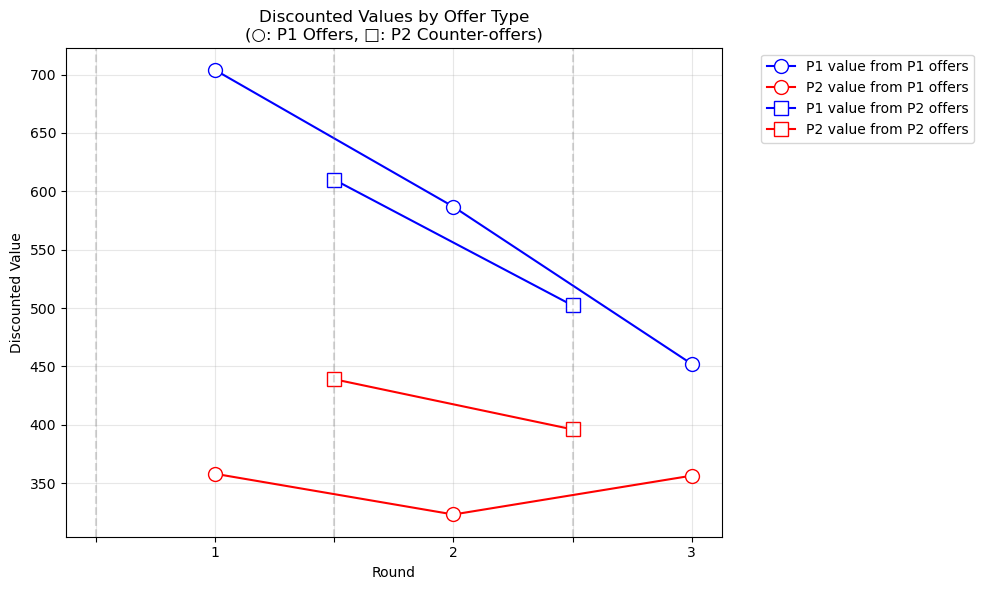

In [147]:
plot_discounted_values(rounds, p1_values, p2_values, max_rounds)


## Offer Evolution Plot

This visualization shows how the distribution of items changes over the negotiation rounds, with a separate subplot for each item type.

### Layout
- Creates a grid of subplots (2 columns)
- One subplot per item type
- For odd number of items, removes unused subplot

### Per Item Subplot
- X-axis: Negotiation rounds
- Y-axis: Number of units offered to P2
- Blue line (○): P1's offers
- Red line (○): P2's counter-offers
- Y-axis range: 0 to maximum units available for that item
- Grid shows valid integer unit values

### Interpretation
- Shows how many units of each item type each player offered to give to P2
- P1's remaining units = total_items - offered_units
- Converging lines suggest agreement being reached
- Diverging lines suggest areas of contention

Number of rounds: 5
Number of P1 offers: 2
Number of P2 offers: 2


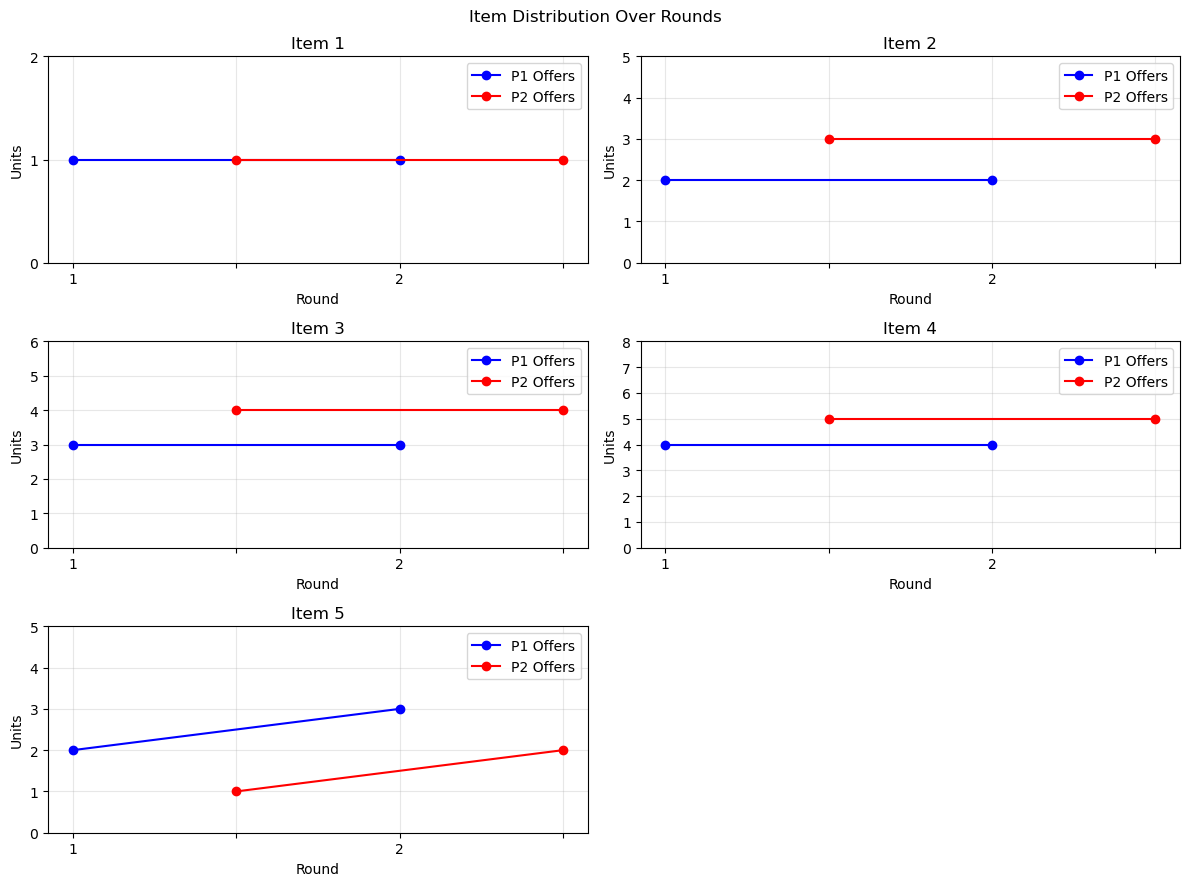

In [145]:
plot_offer_evolution(game, rounds, p1_offers, p2_offers)

In [117]:
def get_final_division(game):
    if game.current_offer: 
        p2_items = game.current_offer.offer  
        p1_items = [t - g for t, g in zip(game.items, p2_items)]  
        return {
            'P1': p1_items,
            'P2': p2_items
        }
    return None
evaluator = GameEvaluator(game)
outside_offer_rational = evaluator.evaluate_outside_offer_consistency()

if game.current_offer:
    final_division = get_final_division(game)
    value_gaps = [abs(p1 - p2) for p1, p2 in zip(p1_values, p2_values)] 
    fairness = [(p1/(p1+p2), p2/(p1+p2)) for p1, p2 in zip(p1_values, p2_values)]  

    print("\nBasic Metrics:")
    print(f"Final P1 Value: {p1_values[-1]:.2f}")
    print(f"Final P2 Value: {p2_values[-1]:.2f}")
    print(f"Final Value Gap: {value_gaps[-1]:.2f}")
    print(f"Final Fairness Ratio: {fairness[-1][0]:.2f} : {fairness[-1][1]:.2f}")
    print("\nFinal Division of Items:")
    if final_division:
        print(f"Total Items Available: {game.items}")
        print(f"P1 Received: {final_division['P1']}")
        print(f"P2 Received: {final_division['P2']}")
    else:
        print("No deal reached - no items were divided")

print("\nNegotiation Evaluation:")
print(f"Outside Offer Rational: {'Yes' if outside_offer_rational else 'No'}")

print(f"P1 Valuation of Each Item: {game.player_values[0]}")
print(f"P2 Valuation of Each Item: {game.player_values[1]}")


Negotiation Evaluation:
Outside Offer Rational: No
P1 Valuation of Each Item: [20 38 82 77  8]
P2 Valuation of Each Item: [51 28 87 79 17]


## Check Pathologies
- Check if Pathologies Occured
- Check Count in game 
- Save to csv
